# Unsupervised Classification on GRS1915+105

So supervised classification doesn't work very well. The maximum number of correctly identified light curves in the test data set is $\sim80\%$. It's not a hundred percent clear whether that has to do with (1) feature extraction, (2) the algorithms that I tried, (3) intrinsic "errors" in the human classification used as training data. 

I specifically put errors in inverted commas, because the original classification by Belloni+ (2000) was never intended to be comprehensive nor statistically sound. They explicitly state that their aim was to describe as much of the behaviour of GRS1915+105 as they could, not taking into account that perhaps some light curves are, in fact, an evolution from one state to another, rather than, e.g. a separate state. Consequently, from now on, we're going to throw away the human classification and do our own thing.

In what follows, we're going to work our way up to a Hidden Markov Model (HMM). For this purpose, we're first going to visualise the feature space using t-SNE. Then we're going to use KMeans++ to do initial clustering, and use that clustering as an input for a Gaussian Mixture Model (GMM), which we can then use to initialize the HMM. 

## Importing and preparing the data.

Boring stuff.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines

import seaborn as sns
sns.set_context("notebook", font_scale=2.5, rc={"axes.labelsize": 26})
plt.rc("font", size=24, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=20, labelsize=20) 
plt.rc("text", usetex=True)

import numpy as np
import cPickle as pickle
from pandas.tools.plotting import scatter_matrix
import pandas as pd

from sklearn import cross_validation
from sklearn.metrics import confusion_matrix
import matplotlib.cm as cmap
from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import metrics


import powerspectrum
import generaltools as gt
#import grs1915_utils 



/scratch/daniela/sw/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
datadir= "../../"
seg_length_unsupervised = 256.

features_train_full = np.loadtxt(datadir+"grs1915_%is_features_train.txt"%seg_length_unsupervised)
features_test_full = np.loadtxt(datadir+"grs1915_%is_features_test.txt"%seg_length_unsupervised)
features_val_full = np.loadtxt(datadir+"grs1915_%is_features_val.txt"%seg_length_unsupervised)

labels_test_full = np.array(gt.conversion(datadir+"grs1915_%is_labels_test.txt"%seg_length_unsupervised)[0])
labels_train_full = np.array(gt.conversion(datadir+"grs1915_%is_labels_train.txt"%seg_length_unsupervised)[0])
labels_val_full = np.array(gt.conversion(datadir+"grs1915_%is_labels_val.txt"%seg_length_unsupervised)[0])

tstart_train_full = np.loadtxt(datadir+"grs1915_%is_tstart_train.txt"%seg_length_unsupervised)
tstart_test_full = np.loadtxt(datadir+"grs1915_%is_tstart_test.txt"%seg_length_unsupervised)
tstart_val_full = np.loadtxt(datadir+"grs1915_%is_tstart_val.txt"%seg_length_unsupervised)


As before, we'll only pick the best 20 features for future analyses, so we'll need to 
reshuffle our features 

In [3]:
feature_ranking = [10, 16, 8, 1, 26, 24, 9, 7, 4, 22, 28, 11, 
                   20, 2, 15, 5, 12, 30, 18, 0, 27, 25, 6, 19, 
                   3, 23, 17, 13, 29, 21, 14]

## we'll be using the first 20 re-ranked features
max_features = 20

## make new empty arrays for the ranked features
features_new_train = np.zeros_like(features_train_full[:,:max_features])
features_new_val = np.zeros_like(features_val_full[:,:max_features])
features_new_test = np.zeros_like(features_test_full[:,:max_features])

for i,f in enumerate(feature_ranking[:max_features]):
    if i in [0,2,3,6,7,11,13,15,16,19,20]:
        print("Making a log of parameter %i"%i)
        features_new_train[:,i] = np.log(features_train_full[:,f])
        features_new_val[:,i] = np.log(features_val_full[:,f])
        features_new_test[:,i] = np.log(features_test_full[:,f])
    else:
        features_new_train[:,i] = features_train_full[:,f]
        features_new_val[:,i] = features_val_full[:,f]
        features_new_test[:,i] = features_test_full[:,f]


Making a log of parameter 0
Making a log of parameter 2
Making a log of parameter 3
Making a log of parameter 6
Making a log of parameter 7
Making a log of parameter 11
Making a log of parameter 13
Making a log of parameter 15
Making a log of parameter 16
Making a log of parameter 19


In the next step, we'll scale all features:


In [4]:
tstart_all = np.hstack((tstart_train_full, tstart_val_full, tstart_test_full))

In [5]:
f_all = np.vstack((features_new_train, features_new_val, features_new_test))

scaler_train = StandardScaler().fit(f_all)
fscaled_train = scaler_train.transform(features_new_train)
fscaled_val = scaler_train.transform(features_new_val)
fscaled_test = scaler_train.transform(features_new_test)


fscaled_train_human = fscaled_train[np.where(labels_train_full != "None")]
fscaled_val_human= fscaled_val[np.where(labels_val_full != "None")]
fscaled_test_human = fscaled_test[np.where(labels_test_full != "None")]

fscaled_train_unclass = fscaled_train[np.where(labels_train_full == "None")]
fscaled_val_unclass = fscaled_val[np.where(labels_val_full == "None")]
fscaled_test_unclass = fscaled_test[np.where(labels_test_full == "None")]

fscaled_all_human = np.vstack((fscaled_train_human, fscaled_val_human, fscaled_test_human))
fscaled_all_unclass = np.vstack((fscaled_train_unclass, fscaled_val_unclass, fscaled_test_unclass))
fscaled_all = np.vstack((fscaled_all_human, fscaled_all_unclass))

labels_train= labels_train_full[np.where(labels_train_full != "None")]
labels_val = labels_val_full[np.where(labels_val_full != "None")]
labels_test = labels_test_full[np.where(labels_test_full != "None")]

labels_train_unclass = labels_train_full[np.where(labels_train_full == "None")]
labels_val_unclass = labels_val_full[np.where(labels_val_full == "None")]
labels_test_unclass = labels_test_full[np.where(labels_test_full == "None")]

labels_all_human = np.hstack((labels_train, labels_val, labels_test))
labels_all_unclass = np.hstack((labels_train_unclass, labels_val_unclass, labels_test_unclass))
labels_all = np.hstack((labels_all_human, labels_all_unclass))


Add the start times to the feature vector, first column

In [6]:
fscaled_all = np.vstack((tstart_all, fscaled_all.T)).T


In [7]:
## make the set of labels
label_set = np.unique(labels_all)

## total number of labels
nlabels = len(label_set)

## make a numeric version of all labels
labels_numeric = np.array([np.where(l == label_set)[0][0] for l in labels_all])

I'm going to need a color palette to use for plotting

In [8]:
from seaborn import color_palette
colors = color_palette("hls", nlabels)
np.savetxt("colors.txt", np.array(colors))

## t-SNE Manifold Plot of the Scaled Data

t-SNE will not be run in the notebook, because it's too computationally expensive and basically needs to be run over night. So we'll run this in a script elsewhere on a cluster, and just load the results.

In [10]:
tsne = gt.getpickle(datadir+"tsne/grs1915_%i_tsne.dat"%seg_length_unsupervised)
asdf = gt.getpickle(datadir+"tsne/grs1915_%i_tsne_projected.dat"%seg_length_unsupervised)

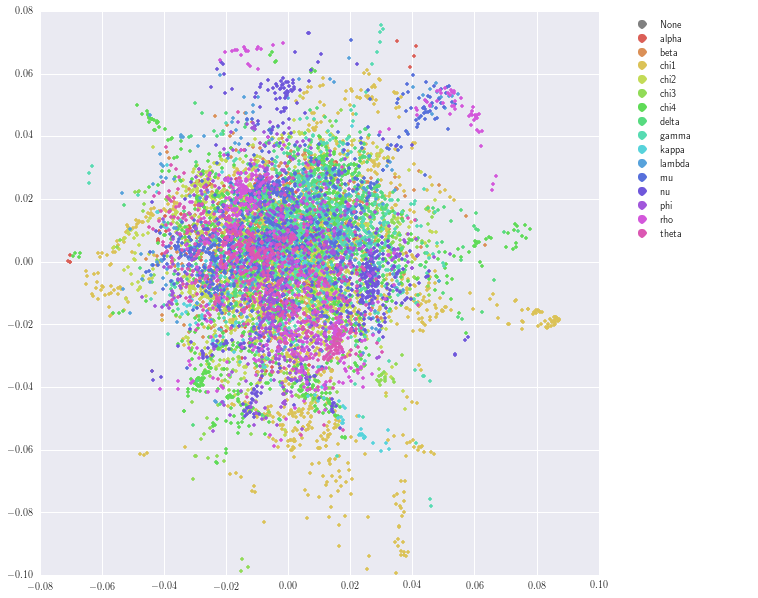

In [23]:
fig = plt.figure(figsize=(11,9))
gs = gridspec.GridSpec(1, 5)

## background is white
sns.set_style("white")
ax = plt.subplot(gs[:,:])
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')

## this is the actual scatter plot
sns.set_context("notebook", font_scale=1.0, rc={"axes.labelsize": 16})
sns.set_style("darkgrid")
plt.rc("font", size=16, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=16, labelsize=16) 
plt.rc("text", usetex=True)

plt.subplots_adjust(top=0.95, bottom=0.08, left=0.08, right=0.97, hspace=0.2)

ax1 = plt.subplot(gs[0,:4])


classified_ind = np.where(labels_all != "None")
asdf_red = asdf[classified_ind]

## loop over all labels, make a scatter plot
colors = ["grey"]
colors.extend(np.loadtxt("colors.txt"))
for k, col in zip(range(nlabels), colors):
    
    my_members = labels_numeric[classified_ind] == k
    ax1.plot(asdf_red[my_members, 0], asdf_red[my_members, 1],".", color=col)

    
    
### Now make a legend on the side of the plot
lines = []
# background of the legend is white
sns.set_style("white")
ax2 = plt.subplot(gs[0,4])
ax2.spines['top'].set_color('none')
ax2.spines['bottom'].set_color('none')
ax2.spines['left'].set_color('none')
ax2.spines['right'].set_color('none')
ax2.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')

## for each label, make a non-existent line
for i,l in enumerate(label_set):
    line = mlines.Line2D([], [], color=colors[i], marker='o',
                          markersize=9, label=l, linewidth=0, zorder=10)
    lines.append(line)

## now actually make the axis
ax2.legend(handles=lines, loc='upper left', shadow=True)

### labels for the entire plot
ax.set_xlabel("Time in MJD", fontsize=18)
ax.set_ylabel("Count rate [counts/s]", fontsize=18)

plt.savefig(datadir+"grs1915_%i_tsne.pdf"%seg_length_unsupervised, format="pdf")    
    


## KMeans Clustering

Can we find clusters in the data using simple, well, clustering? Let's find out!
We're going to do the dumb thing and just run KMeans clustering on the full data set, and then see how that compares to the labels that we know from human classification.

We'll use KMeans++ to initialize the cluster centers, and use up to 30 clusters in total

In [148]:
## run for up to 30 clusters
ari_means, ari_std = [], []
si_means, si_std = [], []
for n in range(2,30,1):
    print("Cross validation for classification with %i clusters \n" 
          "--------------------------------------------------------"%n)
    ## make the samples for 10-fold cross-validation
    kf = cross_validation.KFold(fscaled_all.shape[0], n_folds=10, shuffle=True)
    ari_scores, si_scores = [], []
    ## run through all samples
    for train, test in kf:
        X_train, X_test = fscaled_all[train, 1:], fscaled_all[test, 1:]
        print(X_train.shape)
        y_train, y_test = labels_all[train], labels_all[test]

        kmc = KMeans(init='k-means++', n_clusters=n, n_init=50)
        kmc.fit(X_train)

        pred_labels = kmc.labels_
        
        ## get out those labels that are actually human classified
        classified_ind = np.where(y_train != "None")[0]
        #print(len(classified_ind))
        
        ari_scores.append(metrics.adjusted_rand_score(y_train[classified_ind], pred_labels[classified_ind]))
        #si_scores.append(metrics.silhouette_score(X_train, pred_labels, metric='euclidean'))
        print("Rand Index adjusted for chance: " + 
              str(metrics.adjusted_rand_score(y_train[classified_ind], pred_labels[classified_ind])))
    ari_scores = np.array(ari_scores)
    #si_scores = np.array(si_scores)
    ari_means.append(np.mean(ari_scores))
    ari_std.append(np.std(ari_scores))
    #si_means.append(np.mean(si_scores))
    #si_std.append(np.mean(si_scores))
    ## print mean and standard deviation of the 10 cross-validated scores
    print("Cross-validation adjusted rand score is %.2f +- %.4f. \n"
          "============================================\n"%(np.mean(ari_scores), np.std(ari_scores)))
    
    #print("Cross-validation silhouette score is %.2f +- %.4f. \n"
    #      "============================================\n"%(np.mean(si_scores), np.std(si_scores)))
    

Cross validation for classification with 2 clusters 
--------------------------------------------------------
(55387, 20)
Rand Index adjusted for chance: 0.125990341505
(55387, 20)
Rand Index adjusted for chance: 0.125996419468
(55388, 20)
Rand Index adjusted for chance: 0.126868170692
(55388, 20)
Rand Index adjusted for chance: 0.125767962417
(55388, 20)


KeyboardInterrupt: 

<Container object of 3 artists>

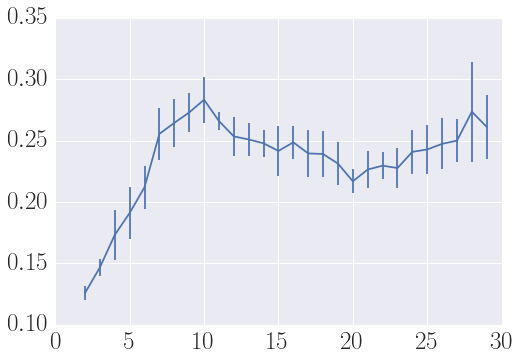

In [14]:
nclusters = np.arange(2,30,1)
plt.errorbar(nclusters, ari_means, yerr=ari_std)

On first try, it looks like 10 clusters is the best representation. Note, however, that this 
analysis is based on the fact that I have 15 "real" classes

In [11]:
nclusters = 10
kmc = KMeans(init='k-means++', n_clusters=nclusters, n_init=50)
kmc.fit(fscaled_all[:,1:])
pred_labels = kmc.labels_

classified_ind = np.where(labels_all != "None")
pred_labels_red = pred_labels[classified_ind]

Let's make a plot of the KMeans result:

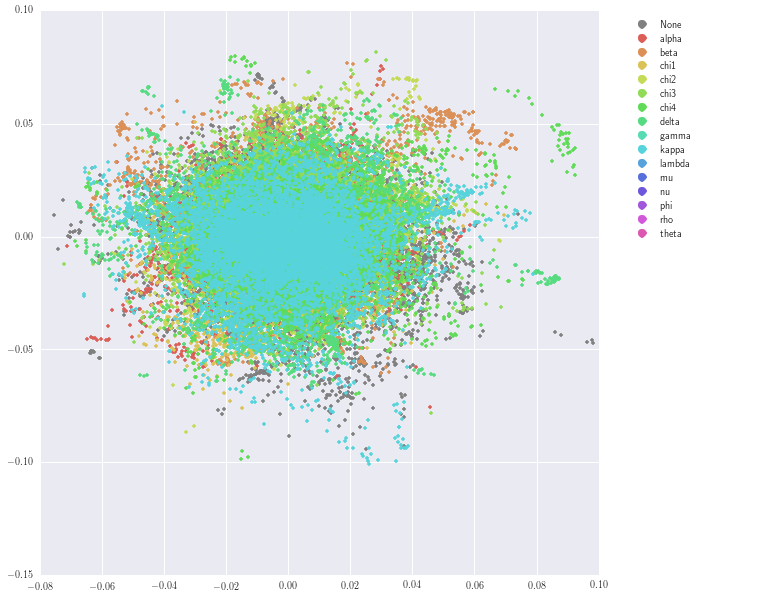

In [19]:
fig = plt.figure(figsize=(11,9))
gs = gridspec.GridSpec(1, 5)

## background is white
sns.set_style("white")
ax = plt.subplot(gs[:,:])
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')

## this is the actual scatter plot
sns.set_context("notebook", font_scale=1.0, rc={"axes.labelsize": 16})
sns.set_style("darkgrid")
plt.rc("font", size=16, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=16, labelsize=16) 
plt.rc("text", usetex=True)

plt.subplots_adjust(top=0.95, bottom=0.08, left=0.08, right=0.97, hspace=0.2)

ax1 = plt.subplot(gs[0,:4])

## loop over all labels, make a scatter plot
colors = ["grey"]
colors.extend(np.loadtxt("colors.txt"))

for k, col in zip(range(nlabels), colors):
    
    my_members = pred_labels == k
    ax1.plot(asdf[my_members, 0], asdf[my_members, 1],".", color=col)

    
    
### Now make a legend on the side of the plot
lines = []
# background of the legend is white
sns.set_style("white")
ax2 = plt.subplot(gs[0,4])
ax2.spines['top'].set_color('none')
ax2.spines['bottom'].set_color('none')
ax2.spines['left'].set_color('none')
ax2.spines['right'].set_color('none')
ax2.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')

## for each label, make a non-existent line
for i,l in enumerate(label_set):
    line = mlines.Line2D([], [], color=colors[i], marker='o',
                          markersize=9, label=l, linewidth=0, zorder=10)
    lines.append(line)

## now actually make the axis
ax2.legend(handles=lines, loc='upper left', shadow=True)

### labels for the entire plot
ax.set_xlabel("Time in MJD", fontsize=18)
ax.set_ylabel("Count rate [counts/s]", fontsize=18)

plt.savefig(datadir+"grs1915_%i_kmeans_tsne.pdf"%seg_length_unsupervised, format="pdf")    
    


I also want to know what the state distribution for different light curves looks like:

In [ ]:
%load_ext autoreload
%autoreload 2
from grs1915_utils import plot_classified_lightcurves

plot_classified_lightcurves(fscaled_all[:,0], pred_labels, "kmeans", "../../")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
n_clusters: 10
2829
i = 0
i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10

In [27]:
pred_label_set = np.unique(pred_labels_red)
unique_labels = np.unique(labels_all_human)

labels_red = labels_all[classified_ind]

## yaxis (rows) predicted labels, x-axis (columns) true labels
cm = np.zeros((len(pred_label_set), len(unique_labels)))
#plt.figure()

for i,p in enumerate(pred_label_set):
    #p = pred_label_set
    clusterno = i
    #print(p)
    pred_mask = np.where((pred_labels_red == p) & (labels_red != "None"))
    hl = labels_all[pred_mask]
    #print(len(hl))
    st = pd.Series(hl)
    nstates = st.value_counts()
    for j,u in enumerate(unique_labels):
        #print(u)
        #print(nstates.keys())
        if u in nstates.keys():
            cm[i,j] = nstates.values[np.where(nstates.keys() == u)[0]]
        else:
            cm[i,j] = 0

#nstates.plot(kind='bar')
#plt.title("Distribution of human-classified states for cluster " + str(p))
    #plt.savefig(datadir+"grs1915_kmeans_clusterid_cluster%i.pdf"%int(p), format="pdf")
    #plt.close()


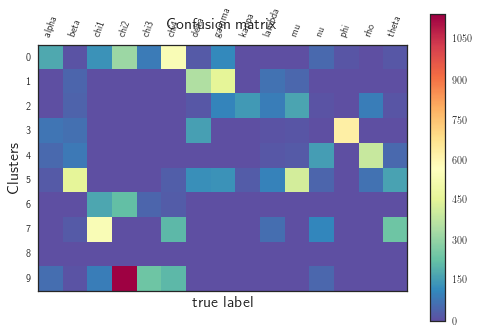

In [28]:
plt.matshow(cm, cmap=cmap.Spectral_r )
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('Clusters')
plt.xlabel('true label')
plt.xticks(range(len(unique_labels)), unique_labels, rotation=70)
plt.yticks(range(len(pred_label_set)), range(len(pred_label_set)))
plt.show()

That looks a bit messy. Let's see how well the KMeans clustering matches up with the human labels.
We'll just go through all of the clusters, and plot the histogram of the human-identified classes in each. 

1528
985
709
977
803
1635
484
1208
1
1828


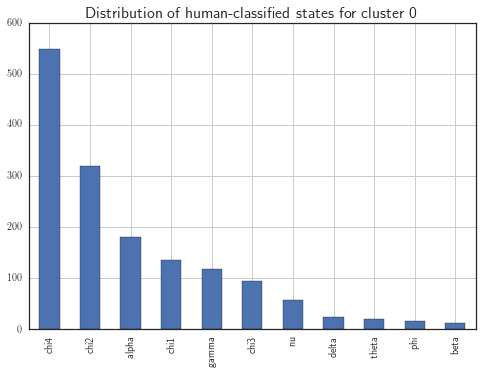

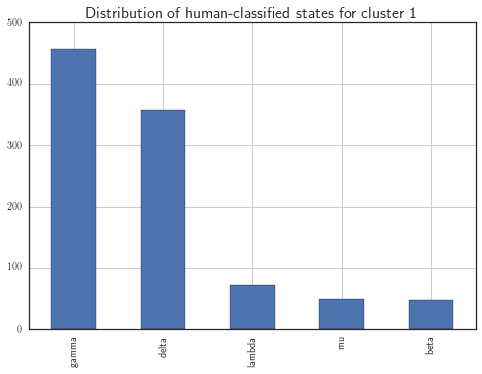

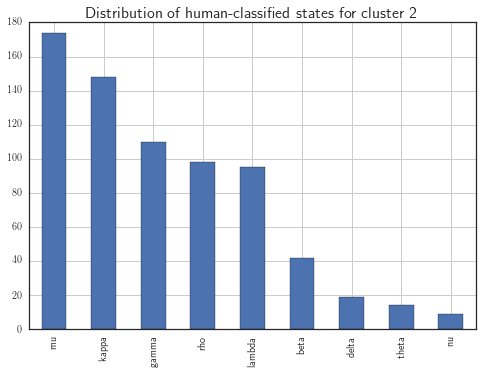

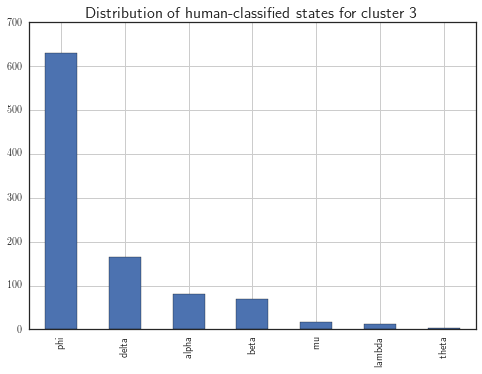

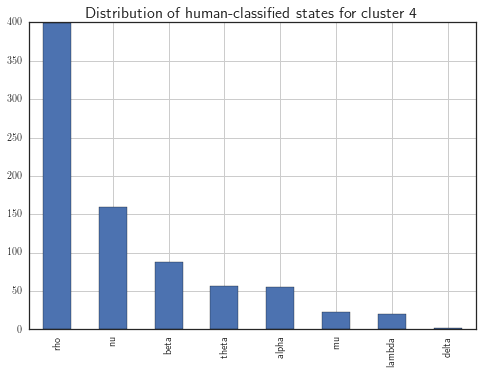

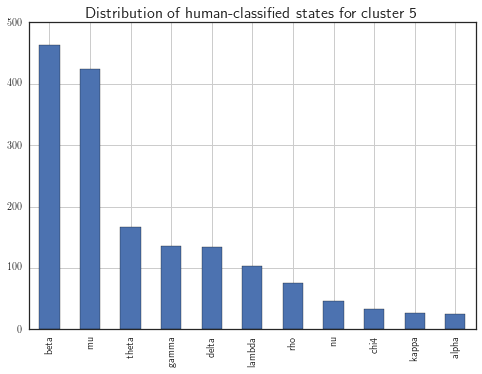

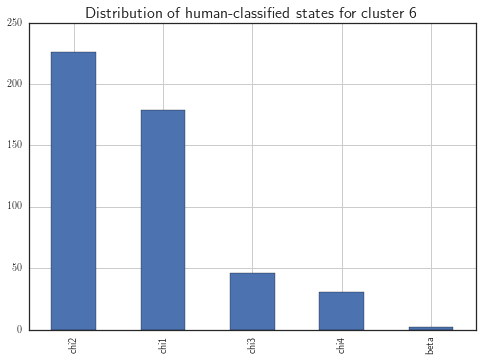

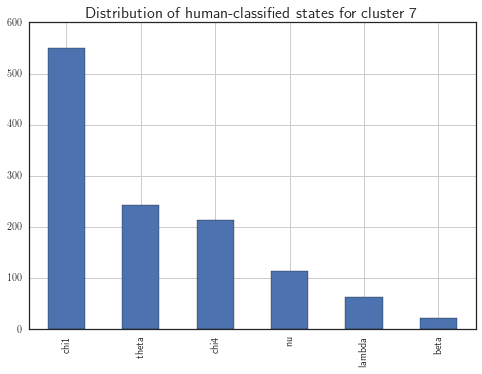

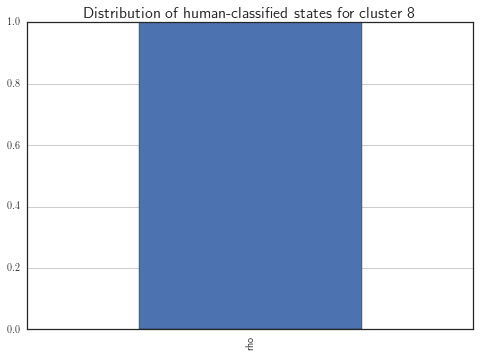

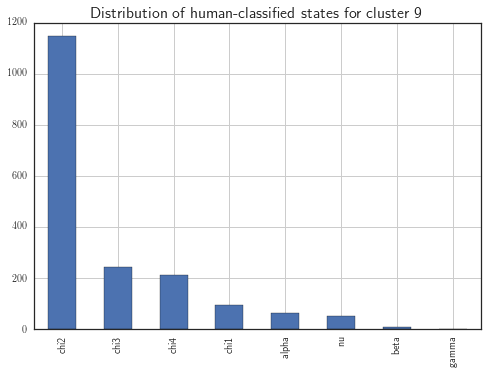

In [30]:
import pandas as pd

for p in pred_label_set:
    #p = pred_label_set[0]
    #print(p)
    plt.figure()
    pred_mask = np.where((pred_labels == p) & (labels_all != "None"))
    hl = labels_all[pred_mask]
    print(len(hl))
    if len(hl) > 0:
        st = pd.Series(hl)
        nstates = st.value_counts()
        nstates.plot(kind='bar')
        plt.title("Distribution of human-classified states for cluster " + str(p))
        #plt.savefig(datadir+"grs1915_kmeans_clusterid_cluster%i.pdf"%int(p), format="pdf")
        #plt.close()
    else:
        continue

This looks pretty good! Although almost no clusters are single-(human-)class, most only split between two or three human classes. Those that split between human classes split along those classes that are also confused in the supervised classification (most notably $\beta$, $\kappa$, $\lambda$ and $\mu$, so we're consistent in that respect.

Some of the $\chi$-states clearly separate out: $\chi_1$ and $\chi_3$ make up one cluster, $\chi_2$ and $\chi_4$ a second. A third cluster, that with the most light curves, actually, contains largely $\chi_2$ and $\chi_4$, with a few $\chi_1$ light curves mixed in. One cluster has many light curves from various different human-classified states. Perhaps these are all one state? Or perhaps these are transition light curves? Who knows?

### MeanShift Clustering

MeanShift Clustering has the advantage that it doesn't require the number of clusters to be known, so let's try that!



In [113]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(fscaled_all, quantile=0.2, n_samples=500)

print(bandwidth)

4.38105101173


In [118]:
## make the samples for 10-fold cross-validation
kf = cross_validation.KFold(fscaled_all.shape[0], n_folds=10, shuffle=True)
ari_scores = []
nclusters = []
## run through all samples
for train, test in kf:
    X_train, X_test = fscaled_all[train, 1:], fscaled_all[test, 1:]
    y_train, y_test = labels_all[train], labels_all[test]

    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(X_train)
    pred_labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    labels_unique = np.unique(pred_labels)
    n_clusters_ = len(labels_unique)
    nclusters.append(n_clusters_)
    print("number of estimated clusters : %d" % n_clusters_)

    ## get out those labels that are actually human classified
    classified_ind = np.where(y_train != "None")[0]
    #print(len(classified_ind))

    ari_scores.append(metrics.adjusted_rand_score(y_train[classified_ind], pred_labels[classified_ind]))
    #si_scores.append(metrics.silhouette_score(X_train, pred_labels, metric='euclidean'))
    print("Rand Index adjusted for chance: " + 
          str(metrics.adjusted_rand_score(y_train[classified_ind], pred_labels[classified_ind])))

ari_scores = np.array(ari_scores)

## print mean and standard deviation of the 10 cross-validated scores
print("Cross-validation adjusted rand score is %.2f +- %.4f. \n"
      "============================================\n"%(np.mean(ari_scores), np.std(ari_scores)))



number of estimated clusters : 3
Rand Index adjusted for chance: 0.000173860511905
number of estimated clusters : 5
Rand Index adjusted for chance: 0.00279736685106
number of estimated clusters : 7
Rand Index adjusted for chance: 0.00319382696166
number of estimated clusters : 6
Rand Index adjusted for chance: 0.00518559041555
number of estimated clusters : 4
Rand Index adjusted for chance: 0.00292674360527
number of estimated clusters : 5
Rand Index adjusted for chance: 0.002868712045
number of estimated clusters : 6
Rand Index adjusted for chance: 0.00296372581234
number of estimated clusters : 5
Rand Index adjusted for chance: 0.00514615589827
number of estimated clusters : 6
Rand Index adjusted for chance: 0.00295135329665
number of estimated clusters : 5
Rand Index adjusted for chance: 0.00295198677875
Cross-validation adjusted rand score is 0.00 +- 0.0013. 



In [119]:
nclusters

[3, 5, 7, 6, 4, 5, 6, 5, 6, 5]

So mean-shift clustering seems to think clusters are anywhere between 3 and 7!
However, the adjusted rand index claims the solution is *nearly* random, although that is with respect to the human classification. 

Let's see what the whole thing looks like spread over the entire time of observations:

In [181]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(fscaled_all[:,1:])
pred_labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(pred_labels)
n_clusters_ = len(labels_unique)

print("Number of clusters: " + str(n_clusters_))


Number of clusters: 5


In [190]:
from grs1915_utils import state_time_evolution

state_time_evolution(fscaled_all[:,0], pred_labels, namestr="grs1915_meanshift", datadir="../../")

The ASM light curve covers a total of 5725 days
I am on plot 0.
I am on plot 1.
I am on plot 2.
I am on plot 3.
I am on plot 4.
I am on plot 5.
I am on plot 6.
I am on plot 7.
I am on plot 8.
I am on plot 9.
I am on plot 10.


In [ ]:
print(fscaled_all[:,0])

In [169]:
f = open("../../grs1915_all_125ms.dat")
d_all = pickle.load(f)
f.close()

## total number of light curves
n_lcs = len(d_all)

## Set the seed to I will always pick out the same light curves.
np.random.seed(20150608)

## shuffle list of light curves
np.random.shuffle(d_all)

train_frac = 0.6
validation_frac = 0.2
test_frac = 0.2

## let's pull out light curves for three data sets into different variables.
d_all_train = d_all[:int(train_frac*n_lcs)]
d_all_val = d_all[int(train_frac*n_lcs):int((train_frac + validation_frac)*n_lcs)]
d_all_test = d_all[int((train_frac + validation_frac)*n_lcs):]

In [180]:
clist = [colors[i] for i in pred_labels]
for i,d in enumerate(d_all_train[:10]):
    data = d[0]
    times = data[:,0]
    counts = data[:,1]
    plt.figure()
    plt.plot(times, counts, lw=1, linestyle="steps-mid")
    mincounts = np.min(counts)
    maxcounts = np.max(counts)
    plt.axis([times[0], times[-1], mincounts-0.1*mincounts, maxcounts+0.1*maxcounts])
    plt.scatter(fscaled_all[:,0], np.ones_like(tstart_all)*1.05*maxcounts, color=clist)
    plt.savefig("../../grs1915_lc%i_meanshift.pdf"%i, format="pdf")
    plt.close()
    
    

array([  3.19800736e+08,   3.19800800e+08,   3.19800864e+08, ...,
         1.16969936e+08,   1.16970000e+08,   1.16970064e+08])

## Classification with a Gaussian Mixture Model

In the next step, we're going to set up a Gaussian Mixture Model (GMM). The feature vector is approximated by an $d$-dimensional Gaussian distribution, where $d$ is the dimension of the feature vector (in our case 12). This asssumes that every feature has a Gaussian distribution around some mean. Because different features will have different values for different (assumed) classes, we will actually need a *mixture* of several 12-dimensional Gaussian distributions to adequately model different (ground truth) states in the system. The parameters of the Gaussian mixtures in 12 dimensions will inform the classification. Note that like KMeans, this approach has no time-variable component. There is no link between subsequent feature vectors in time, thus this model cannot represent time-dependent behaviour, but it's a good starting point for the Hidden Markov Model (HMM), which solves exactly this problem.

We're going to start with a simple Gaussian Mixture Model, where I put the number of components in by hand.

Let's first straight-out compare a model with the number of classes as determined from the human classification with one that has 10 components, as indicated might be the likelier solution by KMeans.

In [33]:
from sklearn.mixture import GMM

n_classes = [15,10]
covar_type = "full"

for n in n_classes:
    gmmc = GMM(n_components=n, covariance_type=covar_type, n_iter=100)
    gmmc.fit(fscaled_all)
    scores = gmmc.score_samples(fscaled_all)
    bic = gmmc.bic(fscaled_all)
    pred_labels = gmmc.predict(fscaled_all)
    adj_rand = metrics.adjusted_rand_score(labels_red, pred_labels[classified_ind])
    print("The Rand index adjusted for chance for %i clusters is %.3f"%(n,adj_rand))
    print("The BIC for %i clusters is %.2f"%(n,bic))



The Rand index adjusted for chance for 15 clusters is 0.297
The BIC for 15 clusters is 3323.25
The Rand index adjusted for chance for 10 clusters is 0.361
The BIC for 10 clusters is 187911.24


In [76]:
## run for up to 30 clusters

covar_type = ['spherical', 'tied', 'diag', 'full']

ari_means_all, ari_std_all = [], []
bic_means_all, bic_std_all = [], []
ari_scores_all, bic_scores_all = [], []

## this should be more, but we'll actually run this in a script,
## the code is in clustering.py
## this is just for demonstration
nclusters = 3


for n in range(2,nclusters,1):
    print("Cross validation for classification with %i clusters \n" 
          "--------------------------------------------------------"%n)
    ## make the samples for 10-fold cross-validation
    kf = cross_validation.KFold(fscaled_all.shape[0], n_folds=10, shuffle=True)
    ## run through all samples
    ari_means, ari_std = [], []
    bic_means, bic_std = [], []
    
    for c in covar_type:
        ari_scores, bic_scores = [], []
        

        print("Running on %s covariance ..."%c)
        
        for train, test in kf:
            X_train, X_test = fscaled_all[train], fscaled_all[test]
            y_train, y_test = labels_all[train], labels_all[test]

            #print("n: " + str(n))
            gmmc = GMM(n_components=n, covariance_type=c, n_iter=100)
            gmmc.fit(X_train)

            bic = gmmc.bic(X_train)
            pred_labels = gmmc.predict(X_test)

            ## get out those labels that are actually human classified
            classified_ind = np.where(y_test != "None")[0]
            #print(len(classified_ind))
            ari_scores.append(metrics.adjusted_rand_score(y_test[classified_ind], pred_labels[classified_ind]))
            bic_scores.append(bic)
            print("BIC: " + str(bic))
            print("Rand Index adjusted for chance: " + 
                  str(metrics.adjusted_rand_score(y_test[classified_ind], pred_labels[classified_ind])))

        ari_scores = np.array(ari_scores)
        bic_scores = np.array(bic_scores)
        ari_means.append(np.mean(ari_scores))
        ari_std.append(np.std(ari_scores))
        bic_means.append(np.mean(bic_scores))
        bic_std.append(np.mean(bic_scores))
        ## print mean and standard deviation of the 10 cross-validated scores
        print("\n Cross-validation adjusted rand score is %.2f +- %.4f."%(np.mean(ari_scores), np.std(ari_scores)))

        print("Cross-validation BIC is %.2f +- %.4f. \n"
              "============================================\n"%(np.mean(bic_scores), np.std(bic_scores)))
    bic_means_all.append(bic_means)
    bic_std_all.append(bic_std)
    ari_means_all.append(ari_means)
    ari_std_all.append(ari_std)

Cross validation for classification with 2 clusters 
--------------------------------------------------------
Running on spherical covariance ...
BIC: 2853769.81026
Rand Index adjusted for chance: 0.119928488041
BIC: 2854064.23521
Rand Index adjusted for chance: 0.143317566305
BIC: 2851029.11967
Rand Index adjusted for chance: 0.135809724089
BIC: 2801307.29191
Rand Index adjusted for chance: 0.124273949539
BIC: 2853147.1729
Rand Index adjusted for chance: 0.133518692577
BIC: 2851199.91295
Rand Index adjusted for chance: 0.127866291699
BIC: 2841294.07374
Rand Index adjusted for chance: 0.12712044445
BIC: 2853715.07224
Rand Index adjusted for chance: 0.137919928945
BIC: 2848876.28344
Rand Index adjusted for chance: 0.124462774661
BIC: 2852003.18436
Rand Index adjusted for chance: 0.120385683411

 Cross-validation adjusted rand score is 0.13 +- 0.0074.
Cross-validation BIC is 2846040.62 +- 15336.9359. 

Running on tied covariance ...
BIC: 1617897.51613
Rand Index adjusted for chance: 0.15

KeyboardInterrupt: 

We've done all this in a script, so here we'll read in the results and plot them:

In [89]:
bic_means = np.loadtxt(datadir+"grs1915_gmm_bic_means.txt")
bic_std = np.loadtxt(datadir+"grs1915_gmm_bic_std.txt")
ari_means = np.loadtxt(datadir+"grs1915_gmm_ari_means.txt")
ari_std = np.loadtxt(datadir+"grs1915_gmm_ari_std.txt")


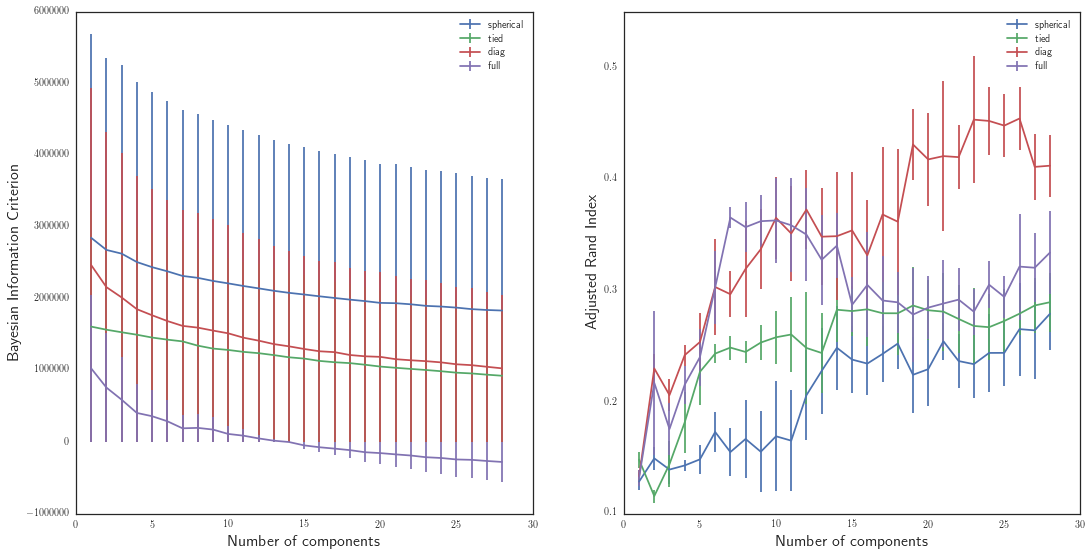

In [88]:
nclusters = np.arange(1,1+len(bic_means), 1)
covar_type = ['spherical', 'tied', 'diag', 'full']

plt.figure(figsize=(18,9))
plt.subplot(121)
for i,c in enumerate(covar_type):
    plt.errorbar(nclusters, bic_means[:,i], yerr=bic_std[:,i], label=c)
plt.legend()
plt.xlabel("Number of components")
plt.ylabel("Bayesian Information Criterion")

plt.subplot(122)
for i,c in enumerate(covar_type):
    plt.errorbar(nclusters, ari_means[:,i], yerr=ari_std[:,i], label=c)

plt.legend()
plt.xlabel("Number of components")
plt.ylabel("Adjusted Rand Index")


This requires us to set the number of components. Instead, we'll try a GMM with a Dirichlet prior. This means that technically, we allow for an infinite number of components, but most will be zero. 

In [90]:
bic_means = np.loadtxt(datadir+"grs1915_dpgmm_bic_means.txt")
bic_std = np.loadtxt(datadir+"grs1915_dpgmm_bic_std.txt")
ari_means = np.loadtxt(datadir+"grs1915_dpgmm_ari_means.txt")
ari_std = np.loadtxt(datadir+"grs1915_dpgmm_ari_std.txt")


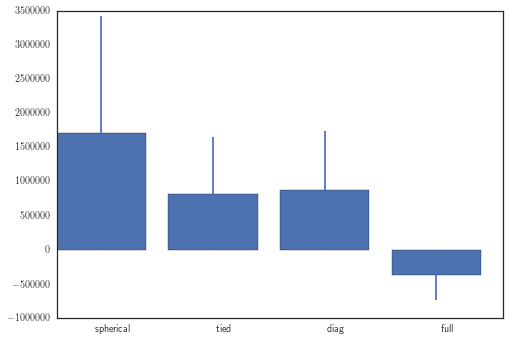

In [107]:
fig = plt.figure()
ax = fig.add_subplot(111)
rects = ax.bar(np.arange(4)+0.5, bic_means, yerr=bic_std)
ax.set_xticks([1,2,3,4])
ax.set_xticklabels(covar_type);

Need to wait for the new run to figure out what the number of components is!

In [ ]:
dpgmm_all = gt.getpickle("")

## Brian's idea: (Non-negative) Matrix Factorization of power spectra

Brian suggested to do non-negative factorization of power spectra, so I'll try that. 
In order to retain the hardness information, I'm going to make power spectra of the hardness ratio light curves. 

Things to play around with
- NMF on (1) the combined data set of both power spectra together, or (2) of them separately, followed by an analysis of correlations between them
- (N)MF on (1) the Fourier amplitudes (squared FFT), (2) the Fourier magnitudes (not squared FFT), (3) log-magnitudes (log of not squared FFTs). The latter two may require unconstrained rather than non-negative matrix factorization


### Feature Extraction

First, we'll need to extract the features, in this case the power spectra of the hardness ratios.
We'll use
- a sliding window
- 1024s long periodograms
- whatever time resolution I've got, hopefully pushing me up to 10Hz

I'm going to cut off any segments shorter than 1024 seconds for now, which'll hurt my date set, but I can still choose smaller segments later. I'm not going to rebin the PSD, we'll see whether that's still ok. 


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import numpy as np
import cPickle as pickle
import pandas as pd
import powerspectrum

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/__init__.py:1312: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
f = open("../grs1915_clean_label_125ms.dat")
d_all = pickle.load(f)
f.close()

In [3]:
print("Number of light curves:  " + str(len(d_all)))
states = [d[1] for d in d_all]
st = pd.Series(states)
st.value_counts()

Number of light curves:  420


chi2      61
chi4      43
delta     40
alpha     36
gamma     30
beta      28
nu        27
mu        27
rho       24
phi       24
theta     22
chi1      20
lambda    17
chi3      15
kappa      6
dtype: int64

In [4]:
## total number of light curves
n_lcs = len(d_all)

## shuffle list of light curves
np.random.shuffle(d_all)

train_frac = 0.7
test_frac = 0.3

## let's pull out light curves for three data sets into different variables.
d_all_train = d_all[:int(train_frac*n_lcs)]
d_all_test = d_all[int(train_frac*n_lcs):]

## Let's print some information about the three sets.
print("There are %i light curves in the training set."%len(d_all_train))
print("There are %i light curves in the test set."%len(d_all_test))
for da,n in zip([d_all_train, d_all_test], ["training", "test"]):
    print("These is the distribution of states in the %s set: "%n)
    states = [d[1] for d in da]
    st = pd.Series(states)
    print(st.value_counts())
    print("================================================================")

There are 294 light curves in the training set.
There are 126 light curves in the test set.
These is the distribution of states in the training set: 
chi2      40
chi4      33
delta     28
alpha     23
nu        21
gamma     20
mu        20
phi       19
rho       18
beta      17
theta     16
chi3      13
lambda    11
chi1      11
kappa      4
dtype: int64
These is the distribution of states in the test set: 
chi2      21
alpha     13
delta     12
beta      11
gamma     10
chi4      10
chi1       9
mu         7
lambda     6
nu         6
theta      6
rho        6
phi        5
chi3       2
kappa      2
dtype: int64


Next, let's extract some segments

In [5]:
## This function is also in grs1915_utils.py!
def extract_segments(d_all, seg_length = 256., overlap=64.):
    """ Extract light curve segmens from a list of light curves. 
        Each element in the list is a list with two elements: 
        - an array that contains the light curve in three energy bands 
        (full, low energies, high energies) and 
        - a string containing the state of that light curve.
        
        The parameters are 
        - seg_length: the length of each segment. Bits of data at the end of a light curve
        that are smaller than seg_length will not be included. 
        - overlap: This is actually the interval between start times of individual segments,
        i.e. by default light curves start 64 seconds apart. The actual overlap is 
        seg_length-overlap
    """
    segments, labels = [], [] ## labels for labelled data
        
    for i,d_seg in enumerate(d_all):
        
        ## data is an array in the first element of d_seg
        data = d_seg[0]
        ## state is a string in the second element of d_seg
        state = d_seg[1]

        ## compute the intervals between adjacent time bins
        dt_data = data[1:,0] - data[:-1,0]
        dt = np.min(dt_data)
        #print("dt: " + str(dt))
        
        ## compute the number of time bins in a segment
        nseg = seg_length/dt
        ## compute the number of time bins to start of next segment
        noverlap = overlap/dt
        
        istart = 0
        iend = nseg
        j = 0
     
        while iend <= len(data):
            dtemp = data[istart:iend]
            segments.append(dtemp)
            labels.append(state)
            istart += noverlap
            iend += noverlap
            j+=1
        
    return segments, labels
    
    

In [6]:
seg_train, labels_train = extract_segments(d_all_train, seg_length=1024., overlap=128.)
seg_test, labels_test = extract_segments(d_all_test, seg_length=1024., overlap=128.)

## Let's print some details on the different segment data sets
print("There are %i segments in the training set."%len(seg_train))
print("There are %i segments in the test set."%len(seg_test))
for la,n in zip([labels_train, labels_test], ["training","test"]):
    print("These is the distribution of states in the %s set: "%n)
    st = pd.Series(la)
    print(st.value_counts())
    print("================================================================")

There are 2014 segments in the training set.
There are 859 segments in the test set.
These is the distribution of states in the training set: 
chi2      283
chi4      190
rho       156
phi       155
beta      152
alpha     143
gamma     141
chi1      137
mu        133
delta     130
chi3      109
theta     100
nu         73
lambda     58
kappa      54
dtype: int64
These is the distribution of states in the test set: 
chi2      179
chi1      105
beta       85
gamma      80
mu         70
chi4       60
alpha      55
lambda     51
phi        48
theta      45
delta      31
nu         20
rho        15
chi3       12
kappa       3
dtype: int64


Now we're ready to make the hardness ratio power spectra

In [9]:
def make_psd(times, counts, navg=1):

    tseg = times[-1]-times[0]
    nlc = len(times)
    nseg = int(nlc/navg) 
    if navg == 1:
        ps = powerspectrum.PowerSpectrum(times, counts=counts, norm="rms")
        return ps.freq, ps.ps
    else:
        ps_all = []
        for n in xrange(navg):
            t_small = times[n*nseg:(n+1)*nseg]
            c_small = counts[n*nseg:(n+1)*nseg]
            ps = powerspectrum.PowerSpectrum(t_small, counts=c_small, norm="rms")
            ps_all.append(ps.ps)
        
        #print(np.array(ps_all).shape) 
    
        ps_all = np.average(np.array(ps_all), axis=0)

        #print(ps_all.shape) 
    
        return ps.freq, ps_all
    
def psd_features(s, navg=1):
    times = s[:,0]
    dt = times[1:] - times[:-1]
    dt = np.min(dt)

    counts = s[:,1]
    low_counts = s[:,2]
    high_counts = s[:,3]
    hr1 = low_counts/counts
    hr2 = high_counts/counts

    freq, psd1 = make_psd(times, hr1, navg=navg)
    freq, psd2 = make_psd(times, hr2, navg=navg)    
    
    return freq, psd1, psd2



In [176]:
f1_train, f2_train, f1_test, f2_test = [], [], [], []

navg = 50

print("seg_train: " + str(len(seg_train)))
for i,s_train in enumerate(seg_train):
    #print(i)
    #print(s_train[1]-s_train[0])
    freq, psd1, psd2 = psd_features(s_train, navg=navg)
    #print(freq[0])
    #print(freq[-1])
    f1_train.append(psd1[1:])
    f2_train.append(psd2[1:])
    
for s_test in seg_test:
    freq, psd1, psd2 = psd_features(s_test, navg=navg)
    f1_test.append(psd1[1:])
    f2_test.append(psd2[1:])


seg_train: 2014


In [180]:
#plt.loglog(freq[1:], f1_train[10])
#plt.loglog(freq[1:], f2_train[10])
#print(len(f1_train))
print(np.array(f1_train).shape)
print(np.array(f1_test).shape)

(2014, 80)
(859, 80)


In [285]:
import librosa
import sklearn.decomposition

S1 = np.transpose(np.array(f1_train))
S2 = np.transpose(np.array(f2_train))


# Decompose a magnitude spectrogram into 32 components with NMF
comps1, acts1 = librosa.decompose.decompose(S1, n_components=50, sort=True)
comps2, acts2 = librosa.decompose.decompose(S2, n_components=50, sort=True)

## Sort components by ascending peak frequency
#comps, acts = librosa.decompose.decompose(S, n_components=32,
#                                         sort=True)

## Or with sparse dictionary learning
#T = sklearn.decomposition.DictionaryLearning(n_components=32)
#comps1, acts1 = librosa.decompose.decompose(S1, transformer=T)
#comps2, acts2 = librosa.decompose.decompose(S2, transformer=T)



KeyboardInterrupt: 

(160, 2014)


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/decomposition/nmf.py:256: UserWarning: Iteration limit reached in nls subproblem.
  warnings.warn("Iteration limit reached in nls subproblem.")


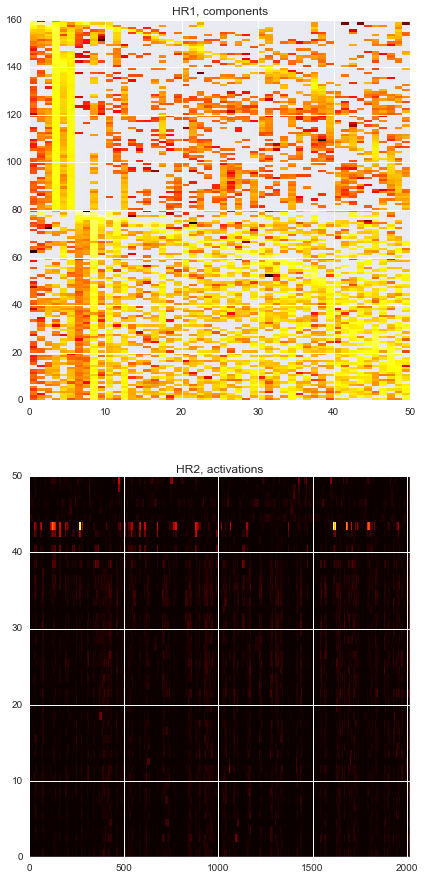

In [288]:
S = np.vstack([S1, S2])
print(S.shape)

comps, acts = librosa.decompose.decompose(S, n_components=50, sort=True)
fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(2,2,1)
ax1.imshow(np.log10(comps),extent=[0,comps.shape[1],0,comps.shape[0]],aspect="auto", cmap="hot", interpolation="None")
ax1.set_title("HR1, components")
 
ax2 = fig.add_subplot(2,2,3) 
ax2.imshow(acts, extent=[0,acts.shape[1],0,acts.shape[0]],aspect="auto", cmap="hot", interpolation="None")
ax2.set_title("HR2, activations")


0.0675182990041
3.90819748935e-05


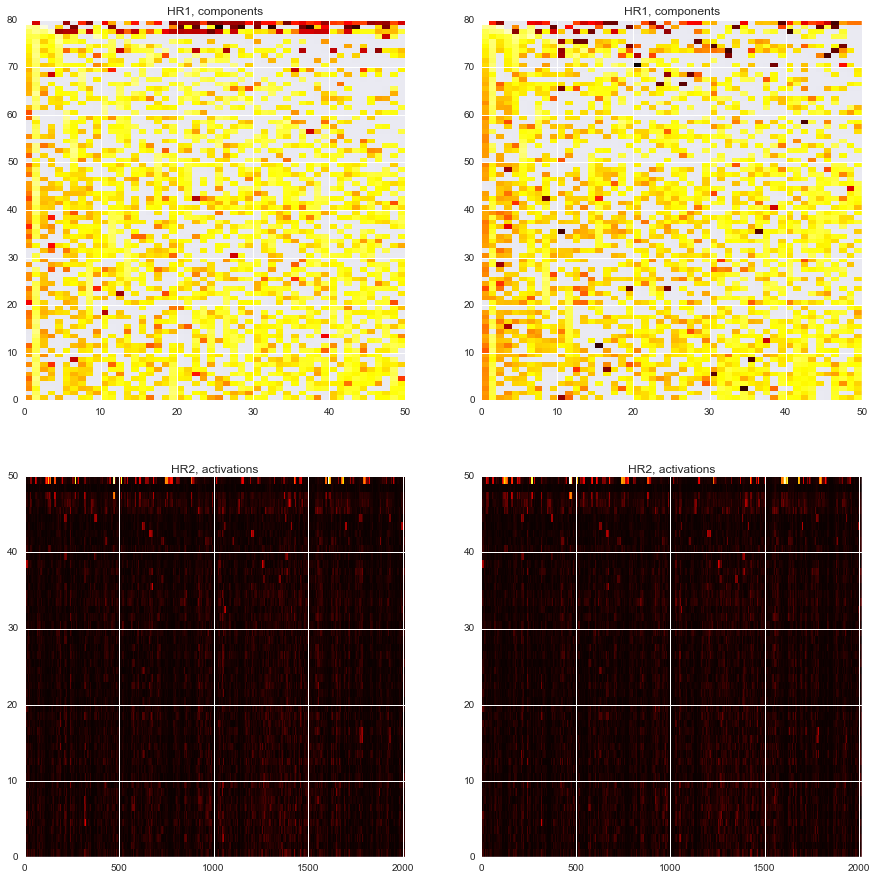

In [279]:
print(np.max(S1))
print(np.min(S1))
#img = plt.imshow(np.log(S))
#img.set_cmap('hot')
fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(2,2,1)
ax1.imshow(np.log10(comps1),extent=[0,comps1.shape[1],0,comps1.shape[0]],aspect="auto", cmap="hot", interpolation="None")
ax1.set_title("HR1, components")
 
ax2 = fig.add_subplot(2,2,3) 
ax2.imshow(acts1, extent=[0,acts1.shape[1],0,acts1.shape[0]],aspect="auto", cmap="hot", interpolation="None")
ax2.set_title("HR2, activations")

ax3 = fig.add_subplot(2,2,2)
ax3.imshow(np.log10(comps2),extent=[0,comps2.shape[1],0,comps2.shape[0]],aspect="auto", cmap="hot", interpolation="None")
ax3.set_title("HR1, components")

ax4 = fig.add_subplot(2,2,4)
ax4.imshow(acts1, extent=[0,acts1.shape[1],0,acts1.shape[0]],aspect="auto", cmap="hot", interpolation="None")
ax4.set_title("HR2, activations")

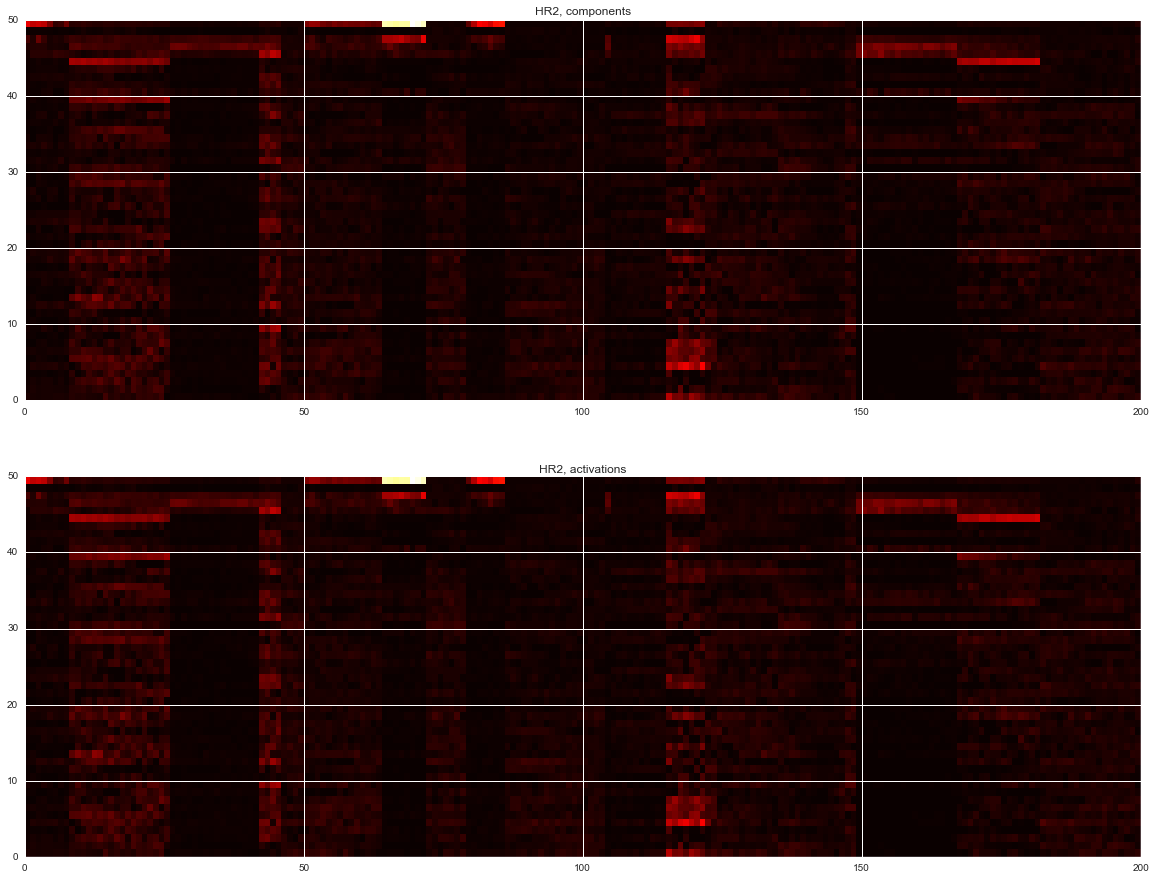

In [122]:
fig = plt.figure(figsize=(20,15))
ax2 = fig.add_subplot(2,1,1) 
ax2.imshow(acts1[:,200:400], extent=[0,200,0,acts1.shape[0]],aspect="auto", cmap="hot", interpolation="None")
ax2.set_title("HR2, components")

ax4 = fig.add_subplot(2,1,2)
ax4.imshow(acts1[:,200:400], extent=[0,200,0,acts1.shape[0]],aspect="auto", cmap="hot", interpolation="None")
ax4.set_title("HR2, activations")

I'm going to sort activations by labels and see whether similar labels have similar activations.

In [134]:
print(len(labels_train))
acts1_t = np.transpose(acts1)
acts2_t = np.transpose(acts2)

label_set = list(set(labels_train))
print(label_set)
acts1_sorted = {}
for l in label_set:
    atemp = [a for a,lt in zip(acts1_t, labels_train) if lt == l]
    acts1_sorted[l] = atemp
    
    
acts2_sorted = {}
for l in label_set:
    atemp = [a for a,lt in zip(acts2_t, labels_train) if lt == l]
    acts2_sorted[l] = atemp

2014
['phi', 'kappa', 'alpha', 'chi2', 'chi3', 'chi1', 'chi4', 'mu', 'beta', 'rho', 'delta', 'theta', 'nu', 'gamma', 'lambda']


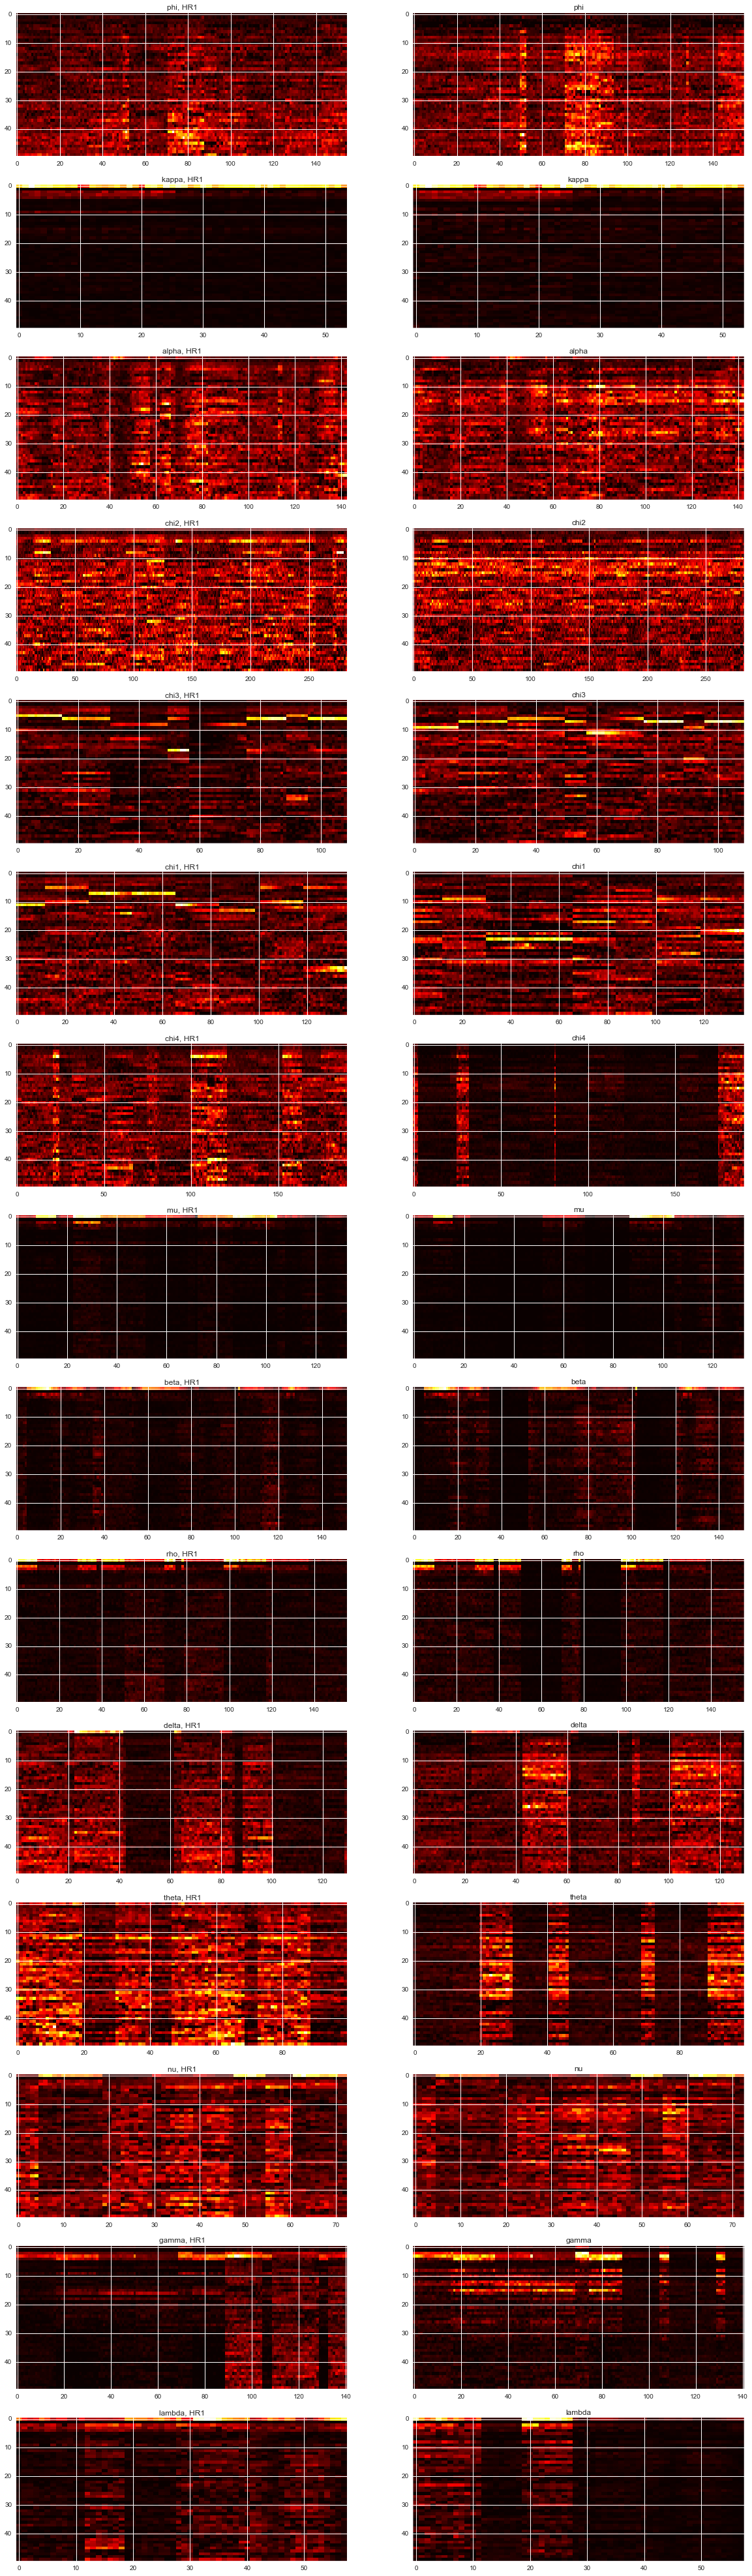

In [136]:
fig = plt.figure(figsize=(20,70))
for i,l in enumerate(label_set):
    ax1 = fig.add_subplot(len(label_set),2,(i)*2+1) 
    ax1.imshow(np.transpose(acts1_sorted[l]), aspect="auto", cmap="hot", interpolation="None")
    ax1.set_title(l + ", HR1")
    
    ax2 = fig.add_subplot(len(label_set),2,(i)*2+2) 
    ax2.imshow(np.transpose(acts2_sorted[l]), aspect="auto", cmap="hot", interpolation="None")
    ax2.set_title(l)
